In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import torch
import cv2
import glob
import json
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.patches as patches
import xml.etree.ElementTree as ET

from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.transforms.functional import to_tensor
from torchinfo import summary
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torchinfo import summary
from torch.nn.utils.rnn import pad_sequence
from tensorflow import keras

In [2]:
BASE_DIR_TEST      = '/kaggle/input/handwriting-recognitionocr/test_v2/test/'
BASE_DIR_TRAIN     = '/kaggle/input/handwriting-recognitionocr/train_v2/train/'
BASE_DIR_VAL       = '/kaggle/input/handwriting-recognitionocr/validation_v2/validation/'
IMAGE_SIZE         = (250, 40)
DEVICE             = "cuda" if torch.cuda.is_available() else "cpu"
EPOCHS             = 15
LEARNING_RATE      = 1e-3
BATCH_SIZE         = 128
OUTPUT             = 50 # Upper Case Only + Blank

In [3]:
train = pd.read_csv('/kaggle/input/handwriting-recognitionocr/CSV/written_name_train.csv')
val = pd.read_csv('/kaggle/input/handwriting-recognitionocr/CSV/written_name_validation.csv')
test = pd.read_csv('/kaggle/input/handwriting-recognitionocr/CSV/written_name_test.csv')

In [4]:
train.head()

,FILENAME,IDENTITY
0,TRAIN_00001.jpg,BALTHAZAR
1,TRAIN_00002.jpg,SIMON
2,TRAIN_00003.jpg,BENES
3,TRAIN_00004.jpg,LA LOVE
4,TRAIN_00005.jpg,DAPHNE


In [5]:
all_characters = ''.join(train['IDENTITY'].astype(str))

# Get unique characters
unique_characters = set(all_characters)

# Print or use the unique characters as needed
print(len(unique_characters))

50


In [11]:
img = cv2.imread('/kaggle/input/handwriting-recognitionocr/train_v2/train/' + train.iloc[0].FILENAME)
print(img.shape)

(50, 284, 3)


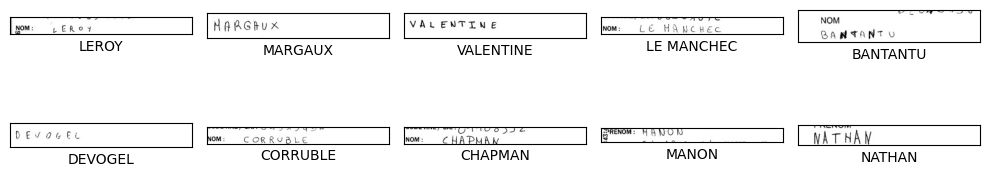

In [12]:
def show_samples(df, num_images=10):
    samples = df.sample(num_images)
    
    count = len(samples)
    rows = 2 # 2 rows
    columns = (count // rows)
    if count % 2 == 1:
        columns += 1
        
    fig, ax = plt.subplots(rows, columns, figsize=(10,3))
    ax = ax.flatten()
    
    for i, (col_idx, col) in enumerate(samples.iterrows()):
        with Image.open(BASE_DIR_TRAIN + col['FILENAME']) as car_image:
            ax[i].imshow(car_image)
            ax[i].set_xlabel(col['IDENTITY'])
            ax[i].set_xticks([])
            ax[i].set_yticks([])
            
    # Remove unused
    for j in range(count, rows * columns):
        fig.delaxes(ax[j])
        
    plt.tight_layout()
    plt.show()
    
show_samples(train, 10)

In [13]:
characters = sorted(unique_characters)
char_to_index = {char: idx+1 for idx, char in enumerate(characters)}
index_to_char = {idx: char for char, idx in char_to_index.items()}

In [14]:
def label_to_indices(label, idx=None, is_train=True):
    return [char_to_index[char] for char in label]

def indices_to_label(indices):
    return ''.join([index_to_char[idx] for idx in indices])

class HandWrittenDataset(Dataset):
    def __init__(self, df, image_size, transforms, directory):
        super(HandWrittenDataset, self).__init__()
        self.df = df
        self.image_size = image_size
        self.transform = transform
        self.directory = directory
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        col = self.df.iloc[idx]
        label = col['IDENTITY']
        image = cv2.imread(self.directory + col['FILENAME'])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # resize image
        image = cv2.resize(image, self.image_size,)
        
        image = self.transform(image)
        label_indices = label_to_indices(str(label))
        return image, label_indices
    
    def collate_fn(self, batch):
        images, labels = zip(*batch)
        # Pad images
        padded_images = torch.nn.functional.pad(pad_sequence(images, batch_first=True), (0, 0, 0, 0))
        # Pad labels
        padded_labels = pad_sequence([torch.tensor(label) for label in labels], batch_first=True, padding_value=0)

        return torch.stack(images), padded_labels

In [16]:
transform = transforms.Compose([
    transforms.ToTensor(),
#     transforms.Resize(IMAGE_SIZE),
#     transforms.RandomRotation(degrees=(-5, 5)),
#     transforms.GaussianBlur(kernel_size=2),
# #     transforms.RandomAffine(degrees=5, shear=5, center=IMAGE_SIZE),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], 
#                          std=[0.229, 0.224, 0.225])
])


train_ds = HandWrittenDataset(train, IMAGE_SIZE, transform, BASE_DIR_TRAIN)
val_ds = HandWrittenDataset(val, IMAGE_SIZE, transform, BASE_DIR_VAL)
test_ds = HandWrittenDataset(test, IMAGE_SIZE, transform, BASE_DIR_TEST)

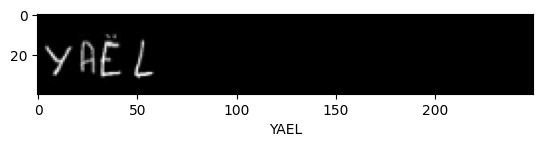

In [17]:
img, label = train_ds[50]
plt.imshow(img.permute(1, 2, 0).numpy(), cmap='binary')
plt.xlabel(indices_to_label(label))
plt.show()

In [18]:
data_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=train_ds.collate_fn)

In [19]:
class CRNN(nn.Module):
    def __init__(self, num_classes, cnn_out_channels=256, rnn_hidden_size=256):
        super(CRNN, self).__init__()
        
        # CNN for feature extraction
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
        )
        
        # RNN for sequence processing
        self.rnn = nn.LSTM(5120, 254, bidirectional=True, batch_first=True, num_layers=1)
        self.rnn2 = nn.LSTM(508, 128, bidirectional=True, batch_first=True, num_layers=1)
        
        # Fully connected layer for classification
        self.fc1 = nn.Linear(128 * 2, 1024)
        self.fc2 = nn.Linear(1024, num_classes)
        self.dropout = nn.Dropout(0.2)
        
        for layer in self.cnn:
            if isinstance(layer, nn.Conv2d):
                nn.init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, x):
        # CNN
        x = self.cnn(x)
        
        # Reshape for RNN
        batch_size, channels, height, width = x.size()
        x = x.permute(0, 3, 1, 2).contiguous()
        x = x.view(batch_size, width, channels * height)
        # RNN
        x, _ = self.rnn(x)
        x, _ = self.rnn2(x)
        # Fully connected layer
#         x = self.fc(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

In [20]:
model = CRNN(len(char_to_index)+1)

summary(model=model,
        input_size=(1, 1, 40, 250),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
CRNN (CRNN)                              [1, 1, 40, 250]      [1, 62, 51]          --                   True
├─Sequential (cnn)                       [1, 1, 40, 250]      [1, 512, 10, 62]     --                   True
│    └─Conv2d (0)                        [1, 1, 40, 250]      [1, 64, 40, 250]     640                  True
│    └─ReLU (1)                          [1, 64, 40, 250]     [1, 64, 40, 250]     --                   --
│    └─MaxPool2d (2)                     [1, 64, 40, 250]     [1, 64, 20, 125]     --                   --
│    └─Conv2d (3)                        [1, 64, 20, 125]     [1, 128, 20, 125]    73,856               True
│    └─ReLU (4)                          [1, 128, 20, 125]    [1, 128, 20, 125]    --                   --
│    └─MaxPool2d (5)                     [1, 128, 20, 125]    [1, 128, 10, 62]     --                   --
│    └─Conv2d (6)     

In [21]:
checkpoint_path = "crnn_checkpoint.pth"

In [28]:
if os.path.exists(f'/kaggle/working/{checkpoint_path}'):
    checkpoint = torch.load(f'/kaggle/working/{checkpoint_path}', map_location=torch.device(DEVICE))
    model.load_state_dict(checkpoint['model_state_dict'])

In [29]:
from tqdm import tqdm

num_epochs = 10
criterion = nn.CTCLoss(blank=0, zero_infinity=False)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
num_epochs = 20
patience = 5

# Training loop
def train_model(model, train_loader, criterion, optimizer, num_epochs=20):
    model.train()
    model.to(DEVICE)
    best_loss = float('inf')
    curr_patience = 0
    
    for epoch in range(num_epochs):
        model.train()
        loop = tqdm(train_loader, leave=True, desc=f'Epoch {epoch + 1}/{num_epochs}')

        total_loss = 0
        correct_predictions = 0
        total_samples = 0

        for batch_idx, (images, labels) in enumerate(loop):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            
            batch_size = images.size(0)
            
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)  # outputs is torch.Size([N, 62, 51]])
            log_probs = outputs  # (T, N, C) based on documentation
            log_probs = nn.functional.log_softmax(log_probs, dim=2).permute(1, 0, 2)
            input_lengths = torch.tensor([len(seq) for seq in outputs])
    
            target_lengths = torch.sum(labels != 0, dim=1)
            target = labels.long()
            
            loss = criterion(log_probs, target, input_lengths, target_lengths)
            
            # Backward pass
            loss.backward()

            # Update weights
            optimizer.step()

            # Update metrics
            total_loss += loss.item()
        
            loop.set_postfix(loss=total_loss / (batch_idx + 1))

        epoch_loss = total_loss / len(train_loader)
        # Save model checkpoint only if it's the best model so far
        if epoch_loss < best_loss:
            print("Saving")
            curr_patience = 0
            best_loss = epoch_loss
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': best_loss,
            }
            torch.save(checkpoint, checkpoint_path)
        else:
            curr_patience += 1
        
        if curr_patience > patience:
            print('Stopping due to patience')
            break
            
#         accuracy = correct_predictions / total_samples
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(train_loader)}')

In [ ]:
train_model(model, data_loader, criterion, optimizer)

In [ ]:
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])

In [30]:
img1, lbl1 = val_ds[900]
img1 = img1.to(DEVICE)

In [31]:
model.eval()
with torch.no_grad():
    output = model(img1.unsqueeze(0)).cpu()

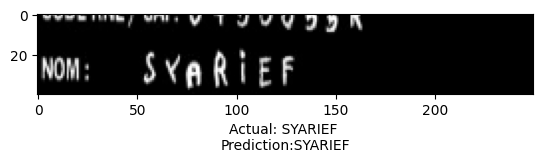

In [37]:
input_len = torch.tensor([len(seq) for seq in output])
preds = keras.backend.ctc_decode(output, input_length=input_len, greedy=True)
decoded = ''.join([index_to_char[x] for x in preds[0][0][0].numpy() if x != 0 and x != -1])

plt.imshow(img1.permute(1, 2, 0).numpy(), cmap='binary')
plt.xlabel(f'Actual: {indices_to_label(lbl1)} \nPrediction:{decoded}')
plt.show()